In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt

@numba.jit(nopython=True)
def in_main_cardioid(c):
    q = (c.real - 1/4)**2 + c.imag**2
    return q*(q + (c.real - 1/4)) <= c.imag**2/4

@numba.jit(nopython=True)
def in_period2bulb(c):
    return (c.real + 1)**2 + c.imag**2 <= 1/16

@numba.vectorize(nopython=True)
def mandelbrot(c, maxiter):
    # --> Check if point is in main cardioid.
    if in_main_cardioid(c): return True
    if in_period2bulb(c): return True
    
    # --> If not, check if it is nonetheless in the
    #     Mandelbrot set.
    x, y = c.real, c.imag
    x2, y2 = x*x, y*y
    for i in range(maxiter):
        if (x2 + y2) > 4:
            return False
            
        y = 2*x*y + c.imag
        x = x2 - y2 + c.real
        x2, y2 = x*x, y*y

    return True

# The Buddhabrot

Now that we know how to make simple visualizations of the Mandelbrot set, let's turn our attention to more advanced ones.
Among these, the most computation-intensive one is probably the [Buddhabrot](https://en.wikipedia.org/wiki/Buddhabrot).
One of its numerous renderings is shown below.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Nebulabrot_%285000%2C_500%2C_50%29.png/600px-Nebulabrot_%285000%2C_500%2C_50%29.png" width="512px" align="center" margin="16px" />

</br>

In the previous section, we made visualizations highlighting if a point $c \in \mathbb{C}$ is in the Mandelbrot (or not) or how fast the dynamical system $z_{k+1} = z^2_k + c$ escaped to infinity.
The Buddhabrot is an entirely different beast.
Rather than focusing on $c$, it depicts the probability distribution over trajectories of points escaping the Mandelbrot set, i.e. the probability distribution of the sequence $z_{k+1} = z^2_k + c$ for all $c$'s outside the Mandelbrot set.
Hence, not only do we need to determine if $c$ is the Mandelbrot set, but we also need to keep track of the whole trajectory generated by the associated quadratic function.
And we need to make sure the image looks nice as well!

Rendering high resolution images of the Buddhabrot can be incredibly hard.
Millions, if not billions of unstable trajectories need to be sampled.
These computations are even more intensive if one wants to zoom in or create an animation.
Benedikt Bitterli has a nice series of [blog posts](https://benedikt-bitterli.me/buddhabrot/) describing how he's been able to render [this video](https://www.youtube.com/watch?v=zxIcydL7wwY&ab_channel=Thunabrain).
In the rest of this section, we'll only try to produce a low-resolution image (300 x 300 pixels) of the Buddhabrot.
This is already challenging enough!
It will nonetheless show the basic techniques or ideas you can use to produce higher resolution images (**Caution**: if you do so, you may have to let your code run for quite a while).


## Simulating a trajectory

The Buddhabrot is the probability distribution over trajectories of points escaping the Mandelbrot.
Getting a good estimate of this probability distribution requires the computation of an extremely large number of such trajectories.
Hence, this is the portion of the code that we need to optimize as much as possible.
Fortunately, most of the work has already been done in the previous section.

In [2]:
@numba.jit(nopython=True)
def trajectory(c, maxiter):
    # --> Compute trajectory.
    z = np.zeros((maxiter, 2), dtype=numba.float64)
    
    x, y = c.real, c.imag
    z[0] = x, y
    x2, y2 = x*x, y*y
    
    for i in range(1, maxiter):
        
        # --> Update point.
        y = 2*x*y + c.imag
        x = x2 - y2 + c.real
        x2, y2 = x*x, y*y
        
        z[i] = x, y

        # --> Check bailout condition.
        if (x2 + y2) > 4:
            break

    return z[:i+1]

The function `trajectory` is almost identical to the function `mandelbrot` we wrote earlier.
It takes as input the value of $c \in \mathbb{C}$ that we consider and the maximum number of iterations `maxiter` beyond which we consider $c$ to be in the Mandelbrot set.
However, it no longer returns `True` or `False`.
Instead, it returns the computed trajectory `z`.
This is pretty much the only difference with our previous piece of code.

## Simple sampling of the trajectories

We know how to simulate efficiently a given trajectory.
Now, how do we estimate the probability distribution?
To do so, we need to sample a large number of different $c$ values and simulate the corresponding trajectories.
If a given trajectory reaches the maximum number of iterations `maxiter`, it is rejected and a new value for $c$ is sampled.
The probability distribution of our data is then obtained using a simple 2D histogram (see `np.histogram2d` for more details).
This process is re-iterated until our estimate converges.

The question thus boils down to **how to sample the $c$ values?**
Sampling the complex plane $\mathbb{C}$ uniformly is probably the simplest thing to do.
Yet, it would be extremely slow.
However, we do know a few things about the Mandelbrot set
- If $c$ is in the main cardioid, it is in the Mandelbrot set.
Hence, we do not even need to simulate the corresponding trajectory.
- Similarly, if $c$ is the period-2 bulb, it is in the Mandelbrot set.
Once again, we don't need to simulate the corresponding trajectory.
- If $\vert c \vert > 2$, $c$ is the not the set.
Moreover, the sequence $z_{k+1} = z_k^2 + c$ grows exponentially fast. The corresponding trajectory would not contribute much to the overall probability distribution.
Once again, we wouldn't need to simulate it.

Our first sampling strategy is thus fairly simple:
1. Sample $c$ uniformly in a disk of radius 2 centered at the origin.
2. If $c$ is in the cardioid or in the period-2 bulb, reject it and go back to 1.
Otherwise, compute the corresponding sequence $\left\{ z_k \right\}$.
3. If the sequence $\left\{ z_k \right\}$ reached the maximum number of iterations allowed, reject it and go back to 1. Otherwise, add it to our dataset.

This process is repeated until we have collected a sufficiently large number of unstable trajectories.
Once this is done, the probability distribution is estimated using a 2D histogram.
The number of bins in each direction will determine the size of the Buddhabrot image we'll render.

The next few cells implement the different steps of our algorithm.
The code should be pretty self-explanatory.

In [3]:
def uniform_sampling():

    # --> Uniform sampling in disk or radius 2.
    r = np.random.uniform(0, 2)
    theta = np.random.uniform(-np.pi, np.pi)
    c = r * np.exp(1j*theta)
    
    # --> Accept/Reject c.
    while in_main_cardioid(c) or in_period2bulb(c):
        return uniform_sampling()
    else:
        return c

In [4]:
def sample_trajectory(maxiter, get_new_sample):

    rejected = True
    
    # --> Sample new trajectory if needed.
    while rejected:
        # --> Sample new c value.
        c = get_new_sample()
        
        # --> New candidate trajectory.
        z = trajectory(c, maxiter)
        
        # --> Accept/Reject trajectory.
        rejected = len(z) == maxiter
    else:
        return z

In [5]:
def generate_data(n, maxiter, get_new_sample):
    
    # --> Initial trajectory.
    z = sample_trajectory(maxiter, get_new_sample)
    
    # --> Add new trajectories to the dataset.
    #     We do so until we have at least n points
    #     in the dataset.
    while len(z) < n:
        k = len(z)
        z = np.append(z, sample_trajectory(maxiter, get_new_sample), axis=0)
    else:
        return z

In [6]:
def compute_image(
    n,                               # Number of points to include in the dataset.
    maxiter=100,                     # Maximum number of iterations.
    get_new_sample=uniform_sampling, # How to sample c.
    nx=301, ny=301):                 # Resolution of the final image.
    
    # --> Generate data.
    data = generate_data(n, maxiter, get_new_sample)
    
    # --> Generate image.
    cr, ci = np.linspace(-2, 2, nx), np.linspace(-2, 2, ny)
    H, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=[cr, ci])
    
    return H

Let's now generate a 300 x 300 image of the Buddhabrot.
We'll sample enough trajectories to have at least 1 000 000 points from which to estimate the probability distribution.

In [7]:
%%time
H_naive = compute_image(nsamples := 10**6, maxiter := 1000)

CPU times: user 4min 39s, sys: 2min 1s, total: 6min 41s
Wall time: 6min 41s


On my laptop, this computation takes 6 to 8 minutes depending on what I'm doing on the side.
Our estimate of the probability distribution (i.e. the "Buddhabrot") is shown below.

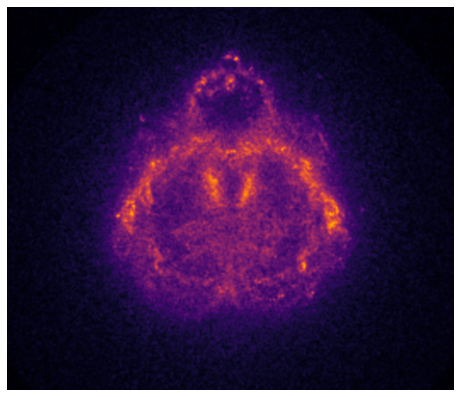

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(
    H_naive, 
    cmap=plt.cm.inferno, 
    extent=[-2, 2, -2, 2],
    interpolation="bicubic"
)

ax.set_aspect("equal")
ax.set_xlim(-1.75, 1.75)
ax.set_ylim(-1.25, 1.75)
ax.axis(False);

The Buddha starts to take shape.
Yet, the image is still pretty noisy.
They are two main reasons for that:
1. We have not sampled enough trajectories.
2. Most of the trajectories we actually sampled are relatively short ones that do not contribute much to the distribution.

One easy fix would be to sample more trajectories, say ten millions instead of one million.
As it is, our sampling strategy is however too naïve to render the image in a reasonable amount of time.
A simple strategy would be change how we sample the $c$ values to make sure we only sample long enough trajectories.
This is what we'll explore next.

## A smarter sampling strategy

When redering the Mandelbrot set with the *escape time algorithm*, we observed that points close to the edges of the Mandelbrot set were the ones taking the longest time to escape.
These are points we want to sample from.
But how to do it?

There are many ways in which we could sample these points of interest.
A simple approach would be to compute the escape time map and select only values of $c$ which take more than `k` iterations to escape.
This would be a perfectly valid strategy.
However I want to illustrate another way using an edge detection technique you can use for image processing.

Given the black and white image of the Mandelbrot set computed in the previous section, the edges are the set of points were the surrounding pixels change from `True` to `False`.
A simple way to identify these points is to compute the gradient of the image.
To do so, one can use the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) already implemented as `scipy.ndimage.sobel`.
This is illustrated below.

In [9]:
from scipy.ndimage import sobel

# --> Complex plane.
nx, ny = 3001, 2501
cr = np.linspace(-2.25, 0.75, nx)
ci = np.linspace(-1.25, 1.25, ny)
c = cr[:, None] + 1j*ci[None, :]

# --> Compute the Mandelbrot set.
M = mandelbrot(c, maxiter)

# --> Compute its edges.
edges = np.abs(sobel(M, axis=0)) + np.abs(sobel(M, axis=1))

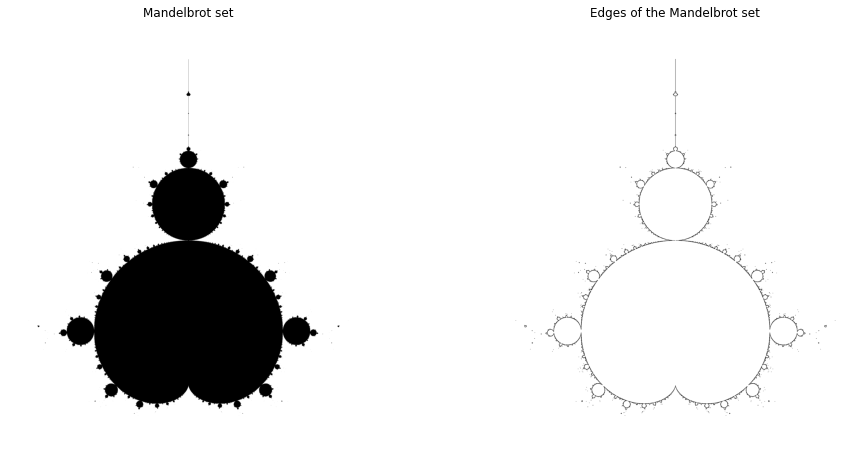

In [10]:
# --> Plot the Mandelbrot set.
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(
    M, 
    extent=[ci.min(), ci.max(), cr.min(), cr.max()],
    cmap=plt.cm.binary)
    
axes[0].set_title("Mandelbrot set")

axes[1].imshow(
    edges, 
    extent=[ci.min(), ci.max(), cr.min(), cr.max()],
    cmap=plt.cm.binary)

axes[1].set_title("Edges of the Mandelbrot set")

for ax in axes:
    ax.set_aspect("equal")
    ax.axis(False);

As you can see, convolving the black and white image of the Mandelbrot set with the Sobel filter indeed detects the edges of the set.
We can then select only these points as shown below.

In [11]:
# --> Points from which to sample.
cs = c[edges == True].ravel()

# --> Scale of the perturbation to be added.
Δx, Δy = cr[1] - cr[0], ci[1]-ci[0]

These are the points we'll sample from.
In order to add a bit more randomness to our sampling algorithm, we'll also slightly perturb each value of $c$ we sample from this set of candidate points.
Our new sampler is implemented in the next cell.

In [12]:
def reject(c):
    return in_main_cardioid(c) or in_period2bulb(c) or np.abs(c)>2

def smart_sampling(cs, Δx, Δy):

    # --> Perturbation to be added to the sampled point.
    Δcr = np.random.uniform(-Δx/2, Δx/2)
    Δci = np.random.uniform(-Δy/2, Δy/2)
    
    Δc = Δcr + 1j*Δci
    
    # --> Value of c to be tested.
    idx = np.random.randint(len(cs))
    c = cs[idx] + Δc
    
    while reject(c):
        return smart_sampling(cs, Δx, Δy)
    else:
        return c

Let's see how efficient our renderer becomes.
We'll once again sample trajectories until our dataset is made of one million different points.

In [13]:
%%time
H_edges = compute_image(nsamples, maxiter=maxiter, get_new_sample=lambda : smart_sampling(cs, Δx, Δy))

CPU times: user 5.99 s, sys: 4.59 ms, total: 6 s
Wall time: 6 s


It now takes only a few seconds to sample the required number of points!
This is a ?x speed-up compared to our naïve sampling strategy.
We can now render the image of our estimated probability distribution.

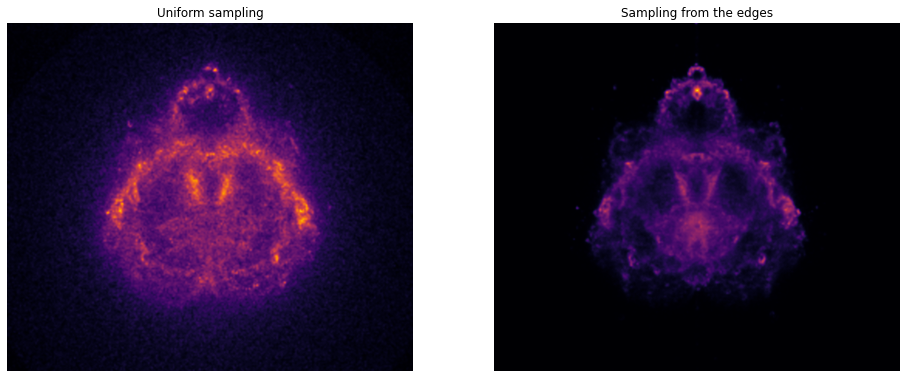

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

axes[0].imshow(
    H_naive, 
    cmap=plt.cm.inferno, 
    extent=[-2, 2, -2, 2],
    interpolation="bicubic"
)

axes[0].set_title("Uniform sampling")

axes[1].imshow(
    H_edges, 
    cmap=plt.cm.inferno, 
    extent=[-2, 2, -2, 2],
    interpolation="bicubic"
)

axes[1].set_title("Sampling from the edges")

for ax in axes:
    ax.set_aspect("equal")
    ax.axis(False);
    ax.set_xlim(-1.75, 1.75)
    ax.set_ylim(-1.25, 1.75)

As expected, the image on the right is much cleaner than the one of the left.
It is much less noisy.
This is a direct consequence of the fact that we now sample only very good candidate trajectories which contribute significantly to the overall distribution.
This is even more visible if we apply a power-law normalization of the pixel intensities before rendering the image.
This can be done with `matplotlib.colors.PowerNorm`.

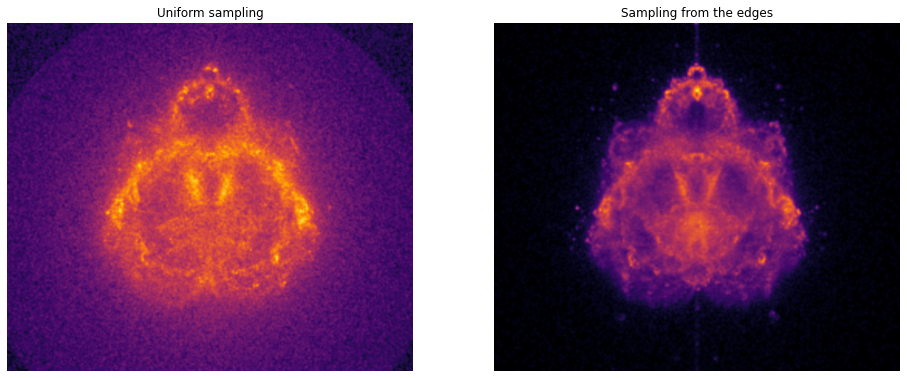

In [15]:
from matplotlib import colors
p = 1/2

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

axes[0].imshow(
    H_naive, 
    cmap=plt.cm.inferno, 
    extent=[-2, 2, -2, 2],
    norm=colors.PowerNorm(p),
    interpolation="bicubic"
)

axes[0].set_title("Uniform sampling")

axes[1].imshow(
    H_edges,
    cmap=plt.cm.inferno, 
    extent=[-2, 2, -2, 2],
    norm=colors.PowerNorm(p),
    interpolation="bicubic"
)

axes[1].set_title("Sampling from the edges")

for ax in axes:
    ax.set_aspect("equal")
    ax.axis(False);
    ax.set_xlim(-1.75, 1.75)
    ax.set_ylim(-1.25, 1.75)

You now know how to render a Buddhabrot!
Even though we have massively improved the speed of our renderer by choosing a better sampling strategy, rendering a high-resolution image (e.g. 1024 x 1024 pixels) will take some time as you'll need to sample hundred of millions of trajectories before your 2D histogram converges.
Running the code over night or during a whole weekend will probably do.

## To go further

The code we've implemented is fairly simple and can be used as the skeleton for more advanced visualizations of the Buddhabrot.
Whether you are a student keen on taking challenges or a teacher looking for project ideas for your classes, here is a non-exhaustive list of how you can build upon this code:

- **False colors:** The very first image of the Buddhabrot shown in this chapter is known as a [Nebulabrot](https://fr.wikipedia.org/wiki/Fichier:Nebulabrot_(5000,_500,_50).png).
It is a RGB image using techniques by NASA to render images of galaxies.
Each color channel corresponds to the probability distribution generated by trajectories with different maximum number of iterations (e.g. the red channel only considers trajectories taking less than 100 iterations to escape, the blue channel is made of trajectories taking less than 1000 iterations and the green channel by trajectories taking less than 10 000 iterations).
- **The Anti-Buddhabrot:** The Buddhabrot is the probability distribution over trajectories of points **outside** the Mandelbrot set.
Only minor modifications of the code are needed to render its dual, the Anti-Buddhabrot, i.e. the probability distribution over trajectories of points **inside** the Mandelbrot set.
An example is shown below.


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Anti-buddabrot.jpg" width="512px" align="center" margin="16px" />

</br>

- **Zooming-in:** Our sampling strategy is good enough when it comes to rendering full-scale images of the Buddhabrot.
Zooming-in is a different story.
Not all points in the vicinity of the edges of the Mandelbrot (nor in $\mathbb{C}$ for that matters) contribute equally to the probability distribution in a particular region of the complex plane.
Rendering zoomed-in images of the Buddhabrot thus necessitate a different sampling strategy.
This is nicely discussed by [Benedikt Bitterli](https://benedikt-bitterli.me/buddhabrot/).
Exploring different sampling strategies to render zoomed-in versions of the Buddhabrot would be an excellent project for anyone interested in rejection sampling, importance sampling or Markov Chain Monte-Carlo simulations!

- **Going parallel:** Sampling different trajectories is embarrassingly parallel.
Nowadays, most computers have multiple CPUs and Python offers some utility packages such as `joblib` to exploit these.
The code below illustrate one possible way to modify the function `compute_image` to sample trajectories in parallel.

In [16]:
from joblib import Parallel, delayed, cpu_count
def compute_image(
    n, 
    maxiter=100, 
    get_new_sample=uniform_sampling,
    nx=301, ny=301,
    n_jobs=cpu_count()):
    
    # --> Generate data.
    if n_jobs == 1:
        data = generate_data(n, maxiter, get_new_sample)
    else:
        data = Parallel(n_jobs=n_jobs)(delayed(generate_data)(n//n_jobs, maxiter, get_new_sample) for i in range(n_jobs))
        data = np.concatenate(data)

    # --> Generate image.
    cr, ci = np.linspace(-2, 2, nx), np.linspace(-2, 2, ny)
    H, _, _ = np.histogram2d(data[:, 0], data[:, 1], bins=[cr, ci])
    
    return H

For more advanced project ideas, you can also think about porting some portions of the code to GPUs or combining false colors images and zooms to make a video deep-diving into the Buddhabrot!
Such a project might take some serious computation time.
Be aware that, if you want to go this way, you may need more than just your laptop...